In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from torchvision import transforms
import glob
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Свёрточная сеть

In [12]:
class data(Dataset):
    def __init__(self, transform=None, mode='train'):
        empty_files = glob.glob('./drive/MyDrive/dataset/empty/*.jpg')[:80]
        in_files = glob.glob('./drive/MyDrive/dataset/in/*.jpg')[:80]
        intersection_files = glob.glob('./drive/MyDrive/dataset/intersection/*.jpg')[:80]
        union_files = glob.glob('./drive/MyDrive/dataset/union/*.jpg')[:80]

        if mode == 'val':
            empty_files = glob.glob('./drive/MyDrive/dataset/empty/*.jpg')[80:]
            in_files = glob.glob('./drive/MyDrive/dataset/in/*.jpg')[80:]
            intersection_files = glob.glob('./drive/MyDrive/dataset/intersection/*.jpg')[80:]
            union_files = glob.glob('./drive/MyDrive/dataset/union/*.jpg')[80:]

        df = list()
        for f in empty_files:
            df.append((f, 0))
        for f in in_files:
            df.append((f, 1))
        for f in intersection_files:
            df.append((f, 2))
        for f in union_files:
            df.append((f, 0))

        self.df = pd.DataFrame(df, columns=['filename', 'label'])
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        image = io.imread(img_path)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
data_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize([32, 32]),
                                     transforms.ToTensor(),
                                    #  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    #                       std=[0.229, 0.224, 0.225]),
                                    ])

train_set = data(transform=data_transform, mode='train')
val_set = data(transform=data_transform, mode='val')

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

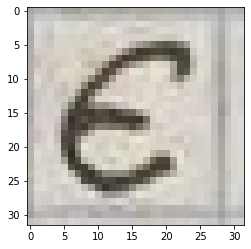

In [14]:
plt.imshow(transforms.ToPILImage()(train_set[100][0]))

In [15]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3),
    nn.MaxPool2d(3),
    nn.ReLU(),
    nn.Conv2d(in_channels=20, out_channels=5, kernel_size=3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(320, 1024),
    nn.ReLU(),
    nn.Linear(1024, 4)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
EPOCHS = 20

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch}')
    train_loss, val_loss, val_accuracy = 0, 0, 0
    num_train_batches = len(train_loader)

    model.train()
    for batch_idx, (samples, targets) in enumerate(train_loader):
        samples = samples.to(device)
        targets = targets.to(device)
        preds = model(samples)
        train_loss = criterion(preds, targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch_idx % 5 == 0:
            print(f'Batch {batch_idx + 1} / {num_train_batches}. Train loss: {train_loss}')

    model.eval()
    num_val_batches = len(val_loader)
    num_val_samples = len(val_loader.dataset)

    for batch_idx, (samples, targets) in enumerate(val_loader):
        samples = samples.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            preds = model(samples)
            val_loss += criterion(preds, targets)
            val_accuracy += (torch.argmax(preds, dim=1) == targets).sum().item()

    val_loss /= num_val_batches
    val_accuracy /= num_val_samples

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f'Avg val loss: {val_loss}, Avg val accuracy = {val_accuracy}\n')

Epoch 0
Batch 1 / 10. Train loss: 1.3760976791381836


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch 6 / 10. Train loss: 0.9344557523727417
Avg val loss: 1.0567432641983032, Avg val accuracy = 0.4936708860759494

Epoch 1
Batch 1 / 10. Train loss: 1.0987470149993896
Batch 6 / 10. Train loss: 1.0518776178359985
Avg val loss: 1.0113632678985596, Avg val accuracy = 0.4936708860759494

Epoch 2
Batch 1 / 10. Train loss: 0.9274579882621765
Batch 6 / 10. Train loss: 0.9468793272972107
Avg val loss: 0.9947460293769836, Avg val accuracy = 0.4936708860759494

Epoch 3
Batch 1 / 10. Train loss: 0.9453129172325134
Batch 6 / 10. Train loss: 0.915672242641449
Avg val loss: 0.8160236477851868, Avg val accuracy = 0.5949367088607594

Epoch 4
Batch 1 / 10. Train loss: 0.8337233662605286
Batch 6 / 10. Train loss: 0.7524537444114685
Avg val loss: 0.5850796699523926, Avg val accuracy = 0.810126582278481

Epoch 5
Batch 1 / 10. Train loss: 0.5636945366859436
Batch 6 / 10. Train loss: 0.3420836925506592
Avg val loss: 0.2923242747783661, Avg val accuracy = 0.9367088607594937

Epoch 6
Batch 1 / 10. Train l

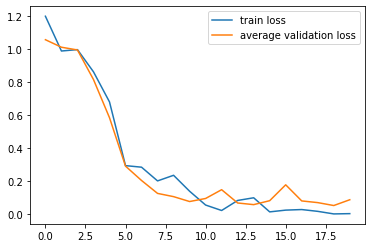

In [17]:
plt.plot(list(range(EPOCHS)), train_losses, label='train loss')
plt.plot(list(range(EPOCHS)), val_losses, label='average validation loss')
plt.legend()

In [18]:
model.eval()

total_correct = 0

for batch_idx, (samples, targets) in enumerate(val_loader):
    samples = samples.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        preds = model(samples)
        total_correct += (torch.argmax(preds, dim=1) == targets).sum().item()

print(f'Total correct: {total_correct}, total images: {len(val_loader.dataset)}')

Total correct: 77, total images: 79


# Теперь работаем с полносвязной сетью

In [24]:
data_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize([32, 32]),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: torch.flatten(x))
                                    ])

train_set = data(transform=data_transform, mode='train')
val_set = data(transform=data_transform, mode='val')

BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
model = nn.Sequential(
    nn.Linear(3072, 6000),
    nn.ReLU(),
    nn.Linear(6000, 1024),
    nn.ReLU(),
    nn.Linear(1024, 4)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
EPOCHS = 20

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch}')
    train_loss, val_loss, val_accuracy = 0, 0, 0
    num_train_batches = len(train_loader)

    model.train()
    for batch_idx, (samples, targets) in enumerate(train_loader):
        samples = samples.to(device)
        targets = targets.to(device)
        preds = model(samples)
        train_loss = criterion(preds, targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch_idx % 5 == 0:
            print(f'Batch {batch_idx + 1} / {num_train_batches}. Train loss: {train_loss}')

    model.eval()
    num_val_batches = len(val_loader)
    num_val_samples = len(val_loader.dataset)

    for batch_idx, (samples, targets) in enumerate(val_loader):
        samples = samples.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            preds = model(samples)
            val_loss += criterion(preds, targets)
            val_accuracy += (torch.argmax(preds, dim=1) == targets).sum().item()

    val_loss /= num_val_batches
    val_accuracy /= num_val_samples

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f'Avg val loss: {val_loss}, Avg val accuracy = {val_accuracy}\n')

Epoch 0
Batch 1 / 10. Train loss: 1.3998271226882935
Batch 6 / 10. Train loss: 1.558022379875183
Avg val loss: 1.1591705083847046, Avg val accuracy = 0.4936708860759494

Epoch 1
Batch 1 / 10. Train loss: 1.2532217502593994
Batch 6 / 10. Train loss: 0.9425053000450134
Avg val loss: 1.0103843212127686, Avg val accuracy = 0.4936708860759494

Epoch 2
Batch 1 / 10. Train loss: 0.9908022284507751
Batch 6 / 10. Train loss: 1.0534955263137817
Avg val loss: 0.8881650567054749, Avg val accuracy = 0.4936708860759494

Epoch 3
Batch 1 / 10. Train loss: 0.8319994211196899
Batch 6 / 10. Train loss: 0.8613348603248596
Avg val loss: 0.7336743474006653, Avg val accuracy = 0.620253164556962

Epoch 4
Batch 1 / 10. Train loss: 0.7450957894325256
Batch 6 / 10. Train loss: 0.6475988626480103
Avg val loss: 0.4574762284755707, Avg val accuracy = 0.8607594936708861

Epoch 5
Batch 1 / 10. Train loss: 0.4172549843788147
Batch 6 / 10. Train loss: 0.45081380009651184
Avg val loss: 0.3604937493801117, Avg val accura

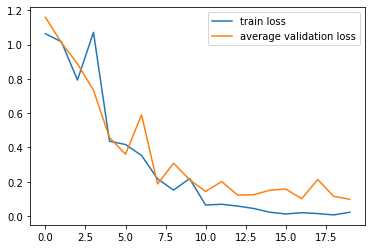

In [27]:
plt.plot(list(range(EPOCHS)), train_losses, label='train loss')
plt.plot(list(range(EPOCHS)), val_losses, label='average validation loss')
plt.legend()

In [28]:
model.eval()

total_correct = 0

for batch_idx, (samples, targets) in enumerate(val_loader):
    samples = samples.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        preds = model(samples)
        total_correct += (torch.argmax(preds, dim=1) == targets).sum().item()

print(f'Total correct: {total_correct}, total images: {len(val_loader.dataset)}')

Total correct: 78, total images: 79
